# Intro to Automatic Differentiation

## *Why do we need it? How does it compare to numerical or symbolic approaches?*

### Stefan Krastanov

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy

In [2]:
def get_mock_training_set(input_dims=3, output_dims=2, samples=1000):
    if input_dims<output_dims:
        raise NotImplementedError('We only do `input_dims >= output_dims` for this mock data.')
    x = np.random.rand(input_dims, samples)*2-1
    noise = np.random.normal(size=(input_dims, samples))*0.05
    y = np.zeros((output_dims, samples))
    for i in range(output_dims):
        y[i,:] = (x[i,:]>0.0)*2-1
    x += noise
    return x,y

def plot_training_set(x, y):
    plt.close('all')
    if x.shape[0]<=2:
        f, axes = plt.subplots(ncols=y.shape[0], figsize=(3*y.shape[0],3))
    elif x.shape[0]>=3:
        f, axes = plt.subplots(ncols=y.shape[0], figsize=(4.7*y.shape[0],4.7), subplot_kw={'projection':'3d'})        
    if y.shape[0] == 1:
        axes = [axes]
    for i,a in enumerate(axes):
        if x.shape[0] == 1:
            print('Too few input dimensions to make an interesting plot...')
        elif x.shape[0] == 2:
            a.scatter(x[0,:],x[1,:],c=y[i,:],vmin=0,vmax=1,alpha=0.5,cmap='coolwarm')
            a.set_aspect('equal')
            a.set_ylim(-1.09,1.09)
            a.set_ylabel('Input dimenion (feature) 2')
        elif x.shape[0] >= 3:
            a.scatter(x[0,:],x[1,:],x[2,:],c=y[i,:],vmin=0,vmax=1,alpha=1.,cmap='coolwarm')
            a.set_aspect('equal')
            a.set_ylim(-1.09,1.09)
            a.set_zlim(-1.09,1.09)
            a.set_ylabel('Input dimenion (feature) 2')
            a.set_zlabel('Input dimenion (feature) 3')
            if x.shape[0] > 3:
                print("Not all input dimensions are shown!")
        a.set_title('Output dimension (label) %d'%(i+1))
        a.set_xlim(-1.09,1.09)
        a.set_xlabel('Input dimenion (feature) 1')
    f.tight_layout()
    return f, axes

# A very simple classification problem

Let us start from the beginning. We will try to create a small classifier and then optimize its parameters until it performs well.

Here we generate some mock training data for a classification problem.

The input is $n=2$ dimensional and the output is $m=2$ dimensional (i.e. there are two labels)

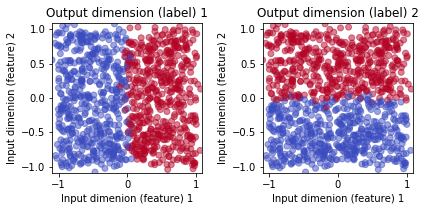

In [3]:
x, y_true = get_mock_training_set(input_dims=2, output_dims=2, samples=1000)
plot_training_set(x, y_true);

Let's us try to make a very simple model...

# $\overrightarrow{\mathrm{labels}} = \mathrm{sigmoid}\left(\mathrm{W}.\overrightarrow{\mathrm{features}}\right)$

In [4]:
def model(parameters, v_in):
    linear_mix = np.dot(parameters, v_in)
    activation =  np.tanh(linear_mix)
    return activation

def cost(parameters, v_in_train, v_out_train):
    return np.sum( (model(parameters, v_in_train) - v_out_train)**2 )

This model requires us to find the appropriate values for the `parameters` matrix. What happens if we just guess...

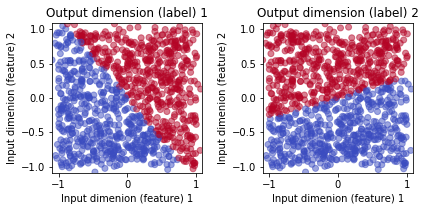

In [5]:
def random_parameters(input_dims, output_dims):
    return np.random.normal(size=(output_dims,input_dims))*0.1

p = random_parameters(2, 2)
y_predicted = model(p, x)

def threshold(y_predicted):
    return (y_predicted > 0)*2 - 1

plot_training_set(x, threshold(y_predicted));

# How can we find better values for the parameters?

Find the direction in which the cost decreases and follow it.

### $\mathrm{\nabla} C(\vec{p}) = \left[
\frac{\partial{C}}{\partial{p_1}}\ 
\frac{\partial{C}}{\partial{p_2}}\ 
\cdots
\right]$

### $\vec{p}_{\text{better}} = \vec{p}_\text{current} - \gamma\ \mathrm{\nabla} C(\vec{p}_\text{current})$

where $\gamma$ is "not too big".

### $\vec{p}_{\text{better}} = \vec{p}_\text{current} - \gamma\ \mathrm{\nabla} C(\vec{p}_\text{current}) $

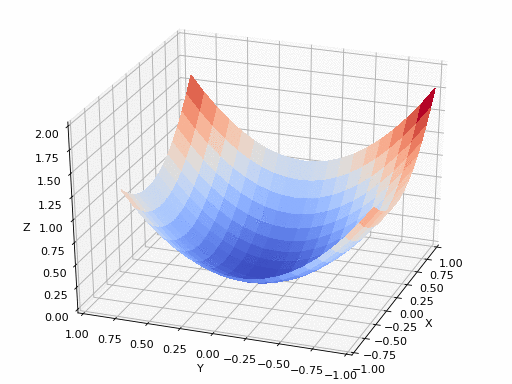

# Many ways to get the gradient...

## *We will discuss the pros and cons of various approaches.*

## *We will implement simple examples of each.*

## *And we will see why "backpropagation" is so frequently used in ML.*

# First Method: Getting the gradient numerically

### $\frac{\partial{C}}{\partial{p_1}} \approx \frac{C(p_1+h,\ p_2,\ \dots)-C(p_1,\ p_2,\ \dots)}{h}$

where $h$ is "rather small".

In [6]:
def numerical_gradient(parameters, function):
    grad_f = np.zeros_like(parameters)
    for i in range(parameters.size):
        h = np.zeros_like(parameters)
        h.flat[i] = 0.0001
        grad_f.flat[i] = (function(parameters+h) - function(parameters))/0.0001
    return grad_f

Did it work?

In [7]:
def f(parameters):
    return cost(parameters, x, y_true)
f(p)

1844.8341121734193

### $\vec{p}_{\text{better}} = \vec{p}_\text{current} - \gamma\ \mathrm{\nabla} C(\vec{p}_\text{current}) $


In [8]:
f(p - 0.0001*numerical_gradient(p, f))

1669.0661898440262

# Testing the gradient descent

### $\vec{p}_{\text{better}} = \vec{p}_\text{current} - \gamma\ \mathrm{\nabla} C(\vec{p}_\text{current}) $

In [9]:
def gradient_descent(parameters, function, gradient_calculator, steps):
    log = [function(parameters)]
    for s in range(steps):
        parameters = parameters - 0.0001 * gradient_calculator(parameters, function)
        log.append(function(parameters))
    plt.plot(log)
    plt.xlabel('step')
    plt.ylabel('function value')
    return parameters

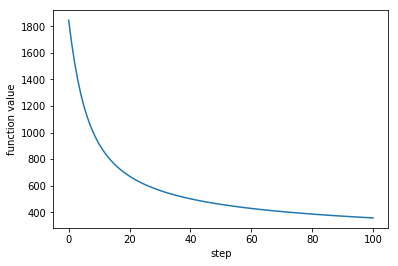

In [10]:
new_p = gradient_descent(p, f, numerical_gradient, 100)

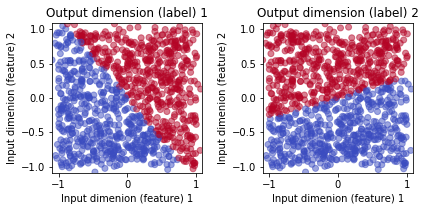

In [11]:
y_predicted = model(p, x) # the initial randomly guessed parameters
plot_training_set(x, threshold(y_predicted));

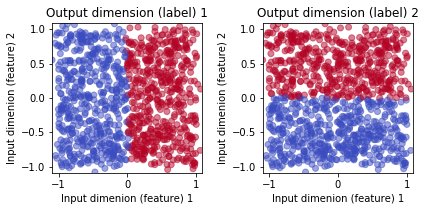

In [12]:
y_predicted = model(new_p, x) # the optimized parameters
plot_training_set(x, threshold(y_predicted));

# Problems?

# Numerical Problem 1: Numerical errors

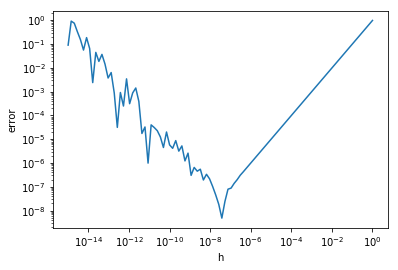

In [13]:
f = lambda p: p**2 + np.sqrt(p+3)
exact_grad_f = lambda p: 2*p + 0.5 / np.sqrt(p+3)

def error_estimate(f, exact_grad_f, p0, h):
    numeric = (f(p0+h) - f(p0)) / h
    return np.abs(exact_grad_f(p0) - numeric)

hs = np.logspace(-15, 0, num=100)
errors = [error_estimate(f, exact_grad_f, 3.5, h) for h in hs]
plt.loglog(hs,errors)
plt.xlabel('h'); plt.ylabel('error');

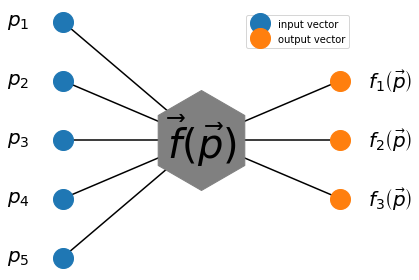

In [14]:
def graphical_representation_of_calculation(input_dims=5, output_dims=3, fa=None, diff=None):
    plt.close('all')
    l = 0
    r = 5
    lo = 0.5-input_dims/2
    ro = 0.5-output_dims/2
    c = (l+r)/2
    if fa is None:
        f, a = plt.subplots()
        for k,v in a.spines.items():
            v.set_visible(False)
        a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
        a.invert_yaxis()
    else:
        f, a = fa
        a.clear()
        a.invert_yaxis()
    for i in range(input_dims):
        a.plot([l,c],[i+lo,0],'k')
    for j in range(output_dims):
        a.plot([r,c],[j+ro,0],'k')
    a.plot(np.ones(input_dims)*l,  np.arange(input_dims)+lo,  'o', ms=20, label='input vector')
    a.plot(np.ones(output_dims)*r, np.arange(output_dims)+ro, 'o', ms=20, label='output vector')
    a.plot([2.5],[0],'h',c='grey',ms=100)
    a.text(c,0,r"$\vec{f}(\vec{p})$", fontsize=40, horizontalalignment='center', verticalalignment='center')
    if diff is None:
        for i in range(input_dims):
            a.text(l-1,i+lo,r"$p_{%d}$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
        for i in range(output_dims):
            a.text(r+0.5,i+ro,r"$f_{%d}\left(\vec{p}\right)$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
    elif diff[0]=='numerical':
        for i in range(input_dims):
            if i==diff[1]:
                a.plot(l,i+lo,'h',ms=24,c='C3')
                a.text(l-1.5,i+lo,r"$p_{%d}+h$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
            else:
                a.text(l-1.5,i+lo,r"$p_{%d}$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
        for i in range(output_dims):
            a.text(r+0.5,i+ro,r"$\partial{f_{%d}}/\partial{p_{%d}}$"%(i+1,diff[1]+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
    elif diff[0]=='forward':
        for i in range(input_dims):
            if i==diff[1]:
                a.text(l-1.8,i+lo,r"$p^\prime_{%d}=1$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
            else:
                a.text(l-1.8,i+lo,r"$p^\prime_{%d}=0$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
        for i in range(output_dims):
            a.text(r+0.5,i+ro,r"$\partial{f_{%d}}/\partial{p_{%d}}$"%(i+1,diff[1]+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
    elif diff[0]=='backward':
        for i in range(input_dims):
            a.text(l-2,i+lo,r"$\partial{f_{%d}}/\partial{p_{%d}}$"%(diff[1]+1, i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
        for i in range(output_dims):
            if i==diff[1]:
                a.plot(r,i+ro,'h',ms=24,c='C3')
                a.text(r+0.5,i+ro,r"$f^\prime_{%d}=1$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
            else:
                a.text(r+0.5,i+ro,r"$f^\prime_{%d}=0$"%(i+1), fontsize=20, horizontalalignment='left', verticalalignment='center')
        
    a.legend()
    f.tight_layout()
    return f,a

from matplotlib import animation

input_dims = 5
output_dims = 3
fa = graphical_representation_of_calculation(input_dims=input_dims, output_dims=output_dims,
                                             #diff=('backward',2)
                                            )

difftype = None
#difftype = 'numerical'
#difftype = 'forward'
#difftype = 'backward'

if difftype is not None:
    animate = lambda i: graphical_representation_of_calculation(input_dims=input_dims, output_dims=output_dims,
                                                                fa=fa, diff=(difftype,i))
    anim = animation.FuncAnimation(fa[0], animate,
                                   frames=input_dims if difftype!='backward' else output_dims,
                                   interval=1000)
    anim.save('/tmp/test.gif',writer='imagemagick')

# Numerical Problem 2: Each parameter requires recalculating $f$

Pictorial representation of a 3-dimensional function of 5 parameters.

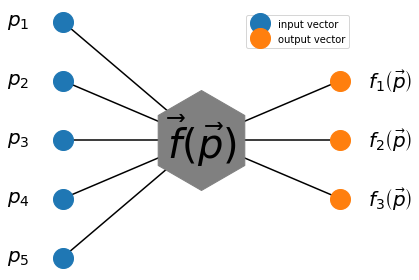

# Numerical Problem 2: Each Parameter Requires recalculating $f$

We need to perturb every single parameter and recalculate $f$.

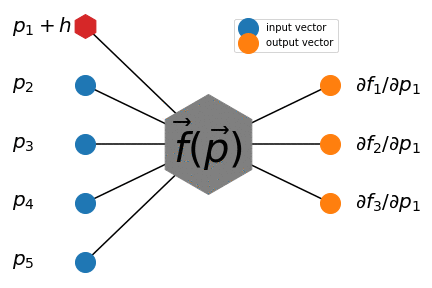

# Numerical Problem 2: Each Parameter Requires recalculating $f$

And ML models frequently have millions of parameters...

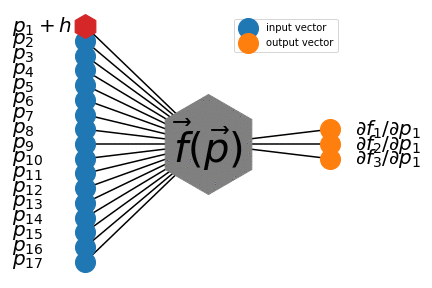

# Second Method: We can do it symbolically!

In [15]:
x = sympy.Symbol('x')

def repeated_layers(n):
    current_layer = x
    for i in range(n):
        current_layer = 4*current_layer*(1-current_layer)
    return current_layer

In [16]:
repeated_layers(5)

1024*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 1)

In [17]:
repeated_layers(5).diff()

1024*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 1) + 1024*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-256*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) - 256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) - 64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(8*x - 4) + 16*x*(-4*x*(1 - x) + 1) + (16*x - 16)*(-4*x*(1 - x) + 1)) + 64*x*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + (64*x - 64)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)) - 256*x*(1

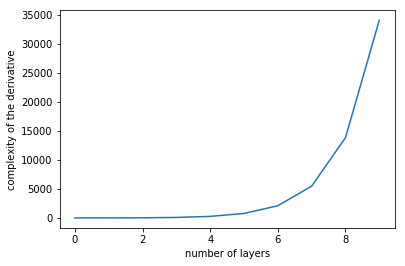

In [18]:
ops = [sympy.count_ops(repeated_layers(n).diff()) for n in range(10)]
plt.plot(ops)
plt.xlabel('number of layers')
plt.ylabel('complexity of the derivative');

# Let's grade these Physics homeworks?

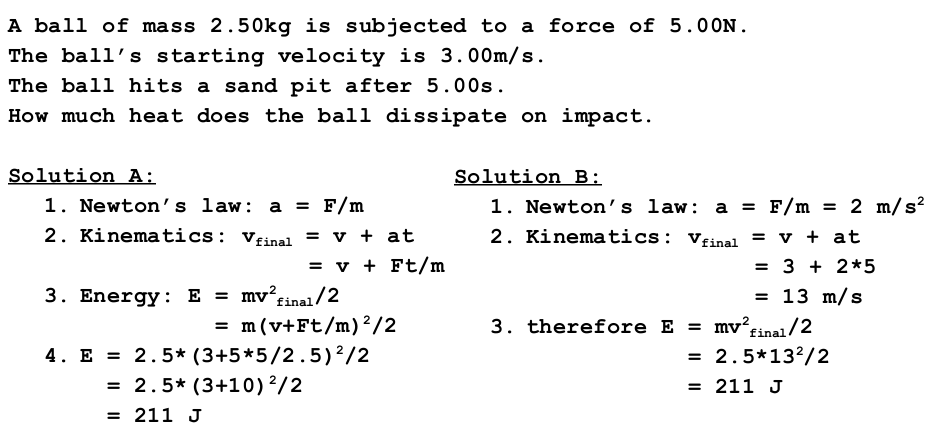

#### Numerical differentiation is simple but slow and noisy.

#### Symbolic differentiation requires dealing with gigantic expressions (and writing completely new code).

#### Automatic differentiation is similar to what student B did: apply the symbolic rule at each step, but compute and save its value immediately!

# Third Method: Forward Mode Automatic Differentiation

Use the chain rule at each step in order to keep track of the intermediate gradients.

## $\frac{\partial f\left(g(x)\right)}{\partial x} = f^\prime\left(g(x)\right)\times g^\prime(x)$

In [19]:
expression = [np.exp, np.tanh]

def forward_automatic_differentiation(expression,input_value):
    current_value = input_value
    current_derivative = 1
    for function in expression[::-1]:
        new_value = function(current_value)
        new_derivative = derivatives[function](current_value) * current_derivative
        current_value, current_derivative = new_value, new_derivative
    return current_value, current_derivative

In [20]:
derivatives = {
    np.exp   :  np.exp,
    np.tanh  :  lambda x: 1 - np.tanh(x)**2,
    np.sin   :  np.cos,
    np.cos   :  lambda x: -np.sin(x)
} # quite an incomplete list

In [21]:
forward_automatic_differentiation([np.exp, np.tanh], 0.5)

(1.587431271429835, 1.2484317246552135)

In [22]:
np.exp(np.tanh(0.5))

1.587431271429835

In [23]:
h = 0.0001
(np.exp(np.tanh(0.5+h)) - np.exp(np.tanh(0.5))) / h

1.2484231190512673

# How expensive is this?

We do need to run it multiple times for each dimension, as was the case for numerical differentiation.

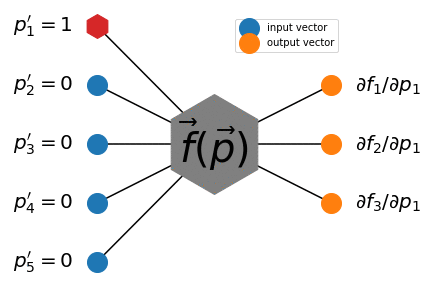

# Forth Method: Backpropagation (a.k.a. Reverse Mode AD)

Calculate the forward pass without calculating derivatives, but while saving the intermediate results.

Go backwards, and calculate the "sensitivity" (a.k.a. the adjoint) of the final expression in terms of its intermediate values.

$y = f(g(h(x)))$

- sensitivity of $y$ w.r.t. itself is $\frac{\partial y}{\partial y} = 1$
- sensitivity of $y$ w.r.t. to the intermediate variable $v_1=g(h(x))$ is $\frac{\partial y}{\partial v_1} = f^\prime (v_1)$
- sensitivity of $y$ w.r.t. to the intermediate variable $v_2=h(x)$ is
$\frac{\partial y}{\partial v_2} =
\frac{\partial y}{\partial v_1}\frac{\partial v_1}{\partial v_2} =
f^\prime (v_1) g^\prime (v_2)$
- etc. until we are all the way back to the sensitivity of $y$ w.r.t. $x$

Pictorially:
    
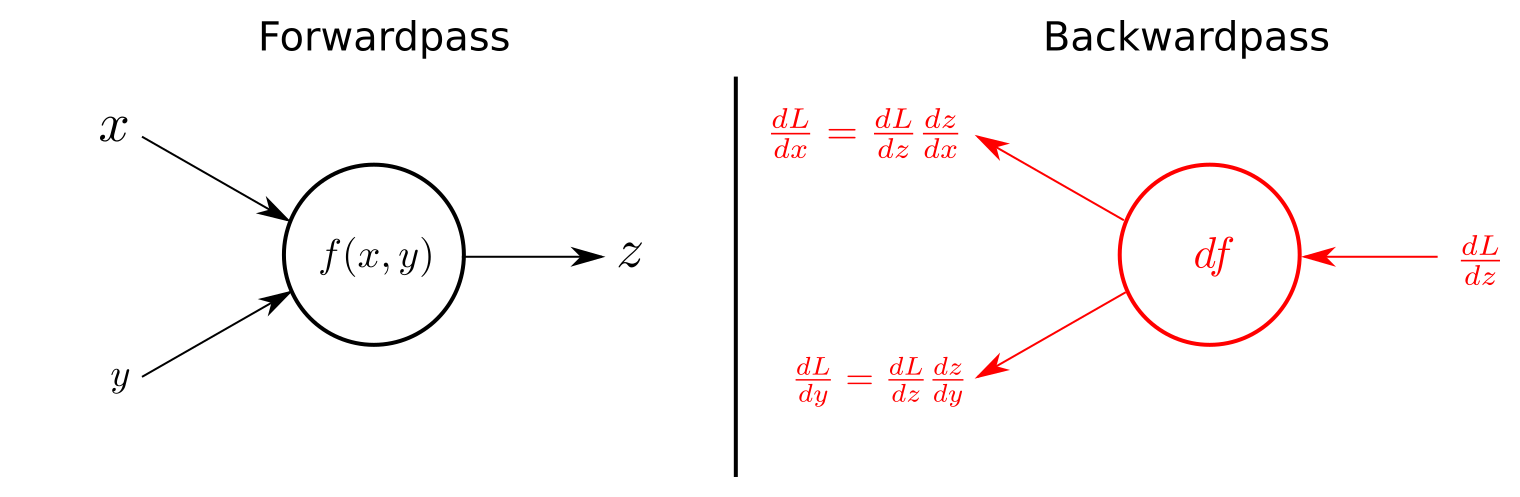

Image credit: Frederik Kratzert

# Let's implement it ourselves!

In [25]:
def reverse_automatic_differentiation(expression,input_value):
    current_value = input_value
    intermediate_values = []
    for function in expression[::-1]:
        intermediate_values.append(current_value)
        current_value = function(current_value)
    current_adjoint = 1
    for function, value in zip(expression, intermediate_values[::-1]):
        current_adjoint = current_adjoint * derivatives[function](value)
    return current_value, current_adjoint

In [26]:
reverse_automatic_differentiation([np.exp, np.tanh], 0.5)

(1.587431271429835, 1.2484317246552135)

# How expensive is this?

We do need to run it multiple times for each output dimension! Good thing that cost functions in ML are scalar.

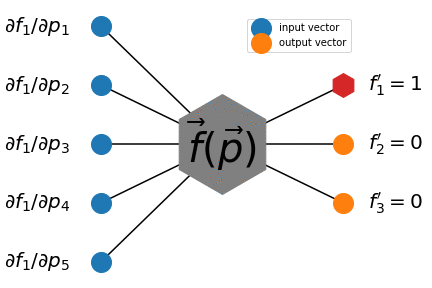

# Takeaways

- Numerical diff. is easy, but expensive and noisy.
- Symbolic diff. is precise, but too unwieldy for large programs.
- Automatic diff. is takes all the great qualities of symbolic diff., but by keeping intermediate gradients (and using the chain rule), is straightforward ot implement efficiently:
    - in forward mode for high-dimensional functions of a few parameters;
    - in backward mode for low-dimensional functions of many parameters.